In [1]:
import torch
from pyqcu.ascend import dslash
from pyqcu.ascend.include import *
# latt_size = (16, 16, 16, 32)
latt_size = (16, 16, 16, 16)
# latt_size = (32, 32, 32, 32)
# latt_size = (32, 32, 32, 64)
# latt_size = (4, 8, 8, 8)
# latt_size = (8, 8, 8, 4)
# latt_size = (16, 8, 8, 8)
# latt_size = (8, 8, 16, 16)
# latt_size = (8, 8, 8, 8)
# latt_size = (4, 4, 4, 4)
kappa = 0.125
# dtype = torch.complex128
dtype = torch.complex64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
# Initialize lattice gauge theory
wilson = dslash.wilson_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
clover = dslash.clover_parity(
    latt_size=latt_size,
    kappa=kappa,
    dtype=dtype,
    device=device,
    verbose=False
)
U = wilson.generate_gauge_field(sigma=0.1, seed=42)

wilson.check_su3(U)
clover_term = clover.make_clover(U=U)
clover_term = clover.add_I(clover=clover_term)  # needed!
# clover_term = clover.add_I(clover=torch.zeros_like(clover_term))  # test

b = torch.randn(4, 3, latt_size[3], latt_size[2], latt_size[1], latt_size[0],
                dtype=dtype, device=device)
U_eo = xxxtzyx2pxxxtzyx(input_array=U)
clover_eo = xxxtzyx2pxxxtzyx(input_array=clover_term)
verbose = False


    @@@@@@######QCU NOTES START######@@@@@@@
    Guide:
    0. Required: MPI(e.g. 4.1.2), CUDA(e.g. 12.4), CMAKE(e.g. 3.22.1), GCC(e.g. 11.4.0), HDF5-MPI(e.g. 1.10.7,'apt install libhdf5-mpi-dev && export HDF5_MPI="ON" && pip install --no-binary=h5py h5py').
    1. The libqcu.so was compiled when pyqcu setup in download_path/PyQCU/lib, please add this path to your LD_LIBRARY_PATH.
    2. The QCU(PyQCU) splite grid by x->y->z->t, lattice by x->y->z->t->p->d->c->c or x->y->z->t->c->s(->p) and x->y->z->t->c->s->c->s(->p).
    3. The QUDA(PyQUDA) splite grid by t->z->y->x, lattice by c->c->x->y->z->t->p->d or c->s->x->y->z->t(->p) and c->s->c->s->x->y->z->t(->p).
    4. The QCU input params in numpy array(dtype=np.int32), argv in  numpy array(dtype=np.float32 or float64) array, set_ptrs in numpy array(dtype=np.int64), other in cupy array(dtype=cp.complex64 or complex128).
    5. The smallest lattice size is (wilson:x=4,y=4,z=4,t=4;clover:x=8,y=8,z=8,t=8) that QCU support (when '#define _B

In [2]:
from pyqcu.ascend import inverse
mg = inverse.mg(b=b, wilson=wilson, U_eo=U_eo,
                clover=clover, clover_eo=clover_eo, verbose=verbose, max_iter=50)

self.dof_list:[12, 8, 4, 2, 12, 12, 12, 8, 4, 2, 4, 4, 24, 12, 12, 12, 4, 4, 4, 4, 4]
Building grid list:
  Level 0: 16x16x16x16
  Level 1: 8x8x8x8
  Level 2: 4x4x4x4
  Level 3: 2x2x2x2
self.grid_list:[[16, 16, 16, 16], [8, 8, 8, 8], [4, 4, 4, 4], [2, 2, 2, 2]]


In [3]:
# b0 = mg.b_list[0]
# b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=b0)
# _b0 = inverse.prolong(local_ortho_null_vecs=mg.lonv_list[0], coarse_vec=b1)
# _b1 = inverse.restrict(
#     local_ortho_null_vecs=mg.lonv_list[0], fine_vec=_b0)
# print(_b1.flatten()[:100]/b1.flatten()[:100])

In [4]:
_x = inverse.bicgstab(b=b, matvec=mg.op_list[0].matvec, verbose=verbose)


Performance Statistics:
Total iterations: 137
Total time: 4.684833 seconds
Average time per iteration: 0.034192 s
Final residual: 9.39e-07



MG:Iteration 1:

Performance Statistics:
Total iterations: 5
Total time: 0.168612 seconds
Average time per iteration: 0.033711 s
Final residual: 4.47e+01

Performance Statistics:
Total iterations: 5
Total time: 0.013938 seconds
Average time per iteration: 0.002785 s
Final residual: 2.29e-07

Performance Statistics:
Total iterations: 3
Total time: 0.015906 seconds
Average time per iteration: 0.005298 s
Final residual: 5.07e-09

Performance Statistics:
Total iterations: 2
Total time: 0.007727 seconds
Average time per iteration: 0.003859 s
Final residual: 4.33e-10

MG:Iteration 2:

Performance Statistics:
Total iterations: 5
Total time: 0.172596 seconds
Average time per iteration: 0.034485 s
Final residual: 1.73e+01

Performance Statistics:
Total iterations: 4
Total time: 0.015716 seconds
Average time per iteration: 0.003926 s
Final residual: 2.54e-07

Performance Statistics:
Total iterations: 1
Total time: 0.003472 seconds
Average time per iteration: 0.003465 s
Final residual: 1.51e-09


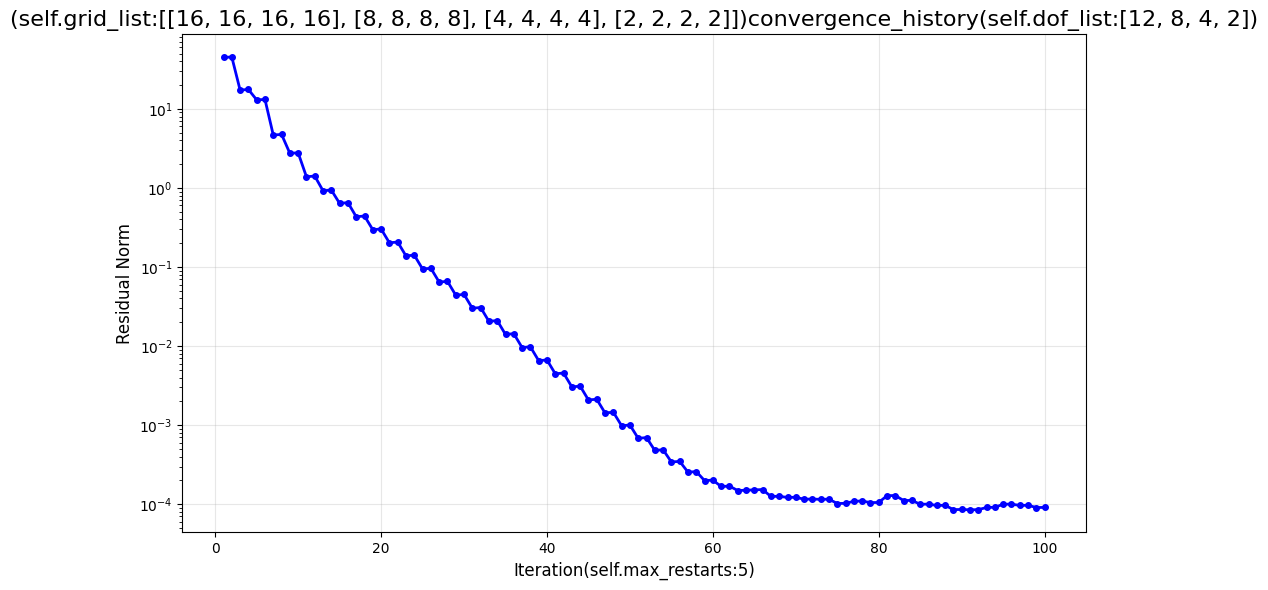

In [5]:
x = mg.solve()
mg.plot()

In [6]:
print(torch.norm(x-_x).item()/torch.norm(_x).item())

4.5233282763639566e-07


In [7]:
_x.flatten()[:100]

tensor([ 0.4236-0.1585j, -1.1921-0.2215j, -1.0872+0.8283j, -0.0100+0.4125j,
         0.5669+0.0587j, -0.7564+0.1209j,  0.6301+1.3608j,  0.5995+0.7564j,
         1.3936+0.8393j,  0.1363+0.9345j, -1.0465+0.3790j,  0.6584-1.5941j,
         2.0296-1.3412j,  0.4802+0.0545j,  1.2516-0.1432j, -0.3154-0.3042j,
        -1.3689-0.2860j, -0.5747-0.4312j, -0.1144+0.5440j,  0.9341-1.0592j,
         1.1229-0.8171j,  0.9772+0.6528j,  1.6944-1.2247j,  1.4692-0.8732j,
        -0.2365+0.2325j, -0.0980+1.3157j, -0.0773+0.2227j,  0.2526-1.1064j,
         0.4786-0.2587j,  0.7726+0.5507j, -0.1339+1.0746j,  0.0268+0.7606j,
         0.4864-1.5195j,  0.6021-0.0881j,  0.7323-0.2174j,  0.0436+0.0465j,
        -0.9297+1.3717j,  0.7292+0.7253j, -0.9457+0.4425j,  0.0719-0.4630j,
         1.6405-0.4440j,  0.8655-0.7417j, -0.9617-0.1087j,  0.6351+0.3799j,
         1.3202+0.3990j,  0.2964+0.0700j, -1.0527-0.6683j, -0.2330-1.0802j,
        -0.9945-0.2440j,  0.2923+0.0452j,  0.3839-0.1603j,  0.8437-0.1440j,
         0.8